In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import holidays
import seaborn as sns
from plotly.subplots import make_subplots

In [2]:
# Load data
file_path = "../data/ChallengeXHEC23022024.xlsx"
excel_data = pd.ExcelFile(file_path)


jan24_df = pd.read_excel(excel_data, sheet_name="JAN24")
clients_df = pd.read_excel(excel_data, sheet_name="clients")
intervenants_df = pd.read_excel(excel_data, sheet_name="intervenants")

In [3]:
jan24_df

,ID Client,ID Intervenant,Date,Heure de début,Heure de fin,Prestation
0,559475456,162858075,2024-01-01,07:15:00,07:45:00,REPAS
1,559277088,162858075,2024-01-01,07:45:00,08:30:00,TOILETTE
2,87852633,78007018,2024-01-01,07:45:00,08:30:00,TOILETTE
3,243033408,810259688,2024-01-01,07:45:00,08:15:00,TOILETTE
4,814940942,710283561,2024-01-01,07:45:00,09:20:00,TOILETTE
...,...,...,...,...,...,...
2865,559277088,710283561,2024-01-31,19:00:00,19:15:00,REPAS
2866,714782168,810259688,2024-01-31,19:00:00,20:00:00,REPAS
2867,559475456,710283561,2024-01-31,19:15:00,20:00:00,TOILETTE
2868,803656603,854577575,2024-01-31,19:20:00,19:50:00,TOILETTE


In [4]:
clients_df

,ID Client,Latitude,Longitude
0,559475456,48.721052,1.375689
1,559277088,48.721052,1.375689
2,87852633,48.691944,1.498773
3,243033408,48.726393,1.332848
4,814940942,48.733174,1.370689
...,...,...,...
113,334442311,48.771381,1.292168
114,621952854,48.742805,1.351704
115,1452858131,48.776801,1.370417
116,846949801,48.733484,1.371047


In [5]:
# Analyze start/end times for each type of service
jan24_df["Heure de début"] = pd.to_datetime(
    jan24_df["Heure de début"], format="%H:%M:%S"
).dt.time
jan24_df["Heure de fin"] = pd.to_datetime(
    jan24_df["Heure de fin"], format="%H:%M:%S"
).dt.time
service_constraints = jan24_df.groupby("Prestation").agg(
    {"Heure de début": ["min", "max"], "Heure de fin": ["min", "max"]}
)
service_constraints.columns = [
    "Start Time Earliest",
    "Start Time Latest",
    "End Time Earliest",
    "End Time Latest",
]
service_constraints.reset_index(inplace=True)


print(service_constraints)

                    Prestation Start Time Earliest Start Time Latest  \
0   ACCOMPAGNEMENTS COURSES PA            08:45:00          17:30:00   
1               ADMINISTRATION            07:30:00          14:30:00   
2                AIDE MENAGERE            08:00:00          18:15:00   
3                 COORDINATION            08:30:00          17:40:00   
4              FEMME DE MENAGE            09:00:00          09:00:00   
5                    FORMATION            08:30:00          19:30:00   
6              GARDE D'ENFANTS            12:00:00          18:20:00   
7          HOMMES TOUTES MAINS            10:00:00          13:00:00   
8                        REPAS            07:00:00          19:45:00   
9                     TOILETTE            07:00:00          20:55:00   
10                 VIE SOCIALE            09:00:00          17:40:00   
11             VISITE MEDICALE            10:20:00          10:20:00   

   End Time Earliest End Time Latest  
0           10:00:00    

In [6]:
prestation_segmented_data = {prestation: group for prestation, group in jan24_df.groupby('Prestation')}


toilette_data = prestation_segmented_data['TOILETTE']  # Replace 'TOILETTE' with the desired service segmented data


In [7]:
# Segment clients according to their needs
client_needs = (
    jan24_df.groupby(["ID Client", "Prestation"]).size().unstack(fill_value=0)
)

print(client_needs)

Prestation  ACCOMPAGNEMENTS COURSES PA  ADMINISTRATION  AIDE MENAGERE  \
ID Client                                                               
78690893                             0               0             28   
78691334                             4               0             13   
78691389                             0               0              5   
78691461                             0               0              4   
78692265                             2               0              5   
...                                ...             ...            ...   
1452740690                           1               0              0   
1452763176                           0               0              3   
1452775101                           0               0              0   
1452858131                           0               0              0   
1453084257                           0               0              2   

Prestation  COORDINATION  FEMME DE MENAGE  FORMATI

In [8]:
# Segment days according to the services offered
jan24_df["Day of Week"] = jan24_df["Date"].dt.dayofweek
jan24_df["Day Type"] = jan24_df["Day of Week"].apply(
    lambda x: "Weekend" if x > 4 else "Weekday"
)
day_segmentation = (
    jan24_df.groupby(["Day Type", "Prestation"]).size().unstack(fill_value=0)
)

day_segmentation.T

Day Type,Weekday,Weekend
Prestation,,
ACCOMPAGNEMENTS COURSES PA,83,0
ADMINISTRATION,79,0
AIDE MENAGERE,435,8
COORDINATION,10,0
FEMME DE MENAGE,4,0
FORMATION,15,0
GARDE D'ENFANTS,10,0
HOMMES TOUTES MAINS,2,0
REPAS,696,214


In [9]:
day_seg_inv = day_segmentation.T
print(
    "Weekday services: ", day_seg_inv[day_seg_inv.Weekday > 0].index.to_list()
)
print(
    "Weekend services: ", day_seg_inv[day_seg_inv.Weekend > 0].index.to_list()
)

Weekday services:  ['ACCOMPAGNEMENTS COURSES PA', 'ADMINISTRATION', 'AIDE MENAGERE', 'COORDINATION', 'FEMME DE MENAGE', 'FORMATION', "GARDE D'ENFANTS", 'HOMMES TOUTES MAINS', 'REPAS', 'TOILETTE', 'VIE SOCIALE', 'VISITE MEDICALE']
Weekend services:  ['AIDE MENAGERE', 'REPAS', 'TOILETTE', 'VIE SOCIALE']


# Plotting agenda of Caretakers

In [10]:
jan24_df["Start DateTime"] = pd.to_datetime(
    jan24_df["Date"].astype(str) + " " + jan24_df["Heure de début"].astype(str)
)
jan24_df["End DateTime"] = pd.to_datetime(
    jan24_df["Date"].astype(str) + " " + jan24_df["Heure de fin"].astype(str)
)

In [11]:
# TODO: add commute time & waittime
# TODO: add client id in hover description

In [12]:
def plot_agenda_for_intervenant(intervenant_id):
    intervenant_agenda = jan24_df[jan24_df["ID Intervenant"] == intervenant_id]
    intervenant_agenda_sorted = intervenant_agenda.sort_values(
        by=["Date", "Heure de début"]
    )

    df_timeline = intervenant_agenda_sorted.copy()
    df_timeline["Start"] = pd.to_datetime(df_timeline["Start DateTime"])
    df_timeline["Finish"] = pd.to_datetime(df_timeline["End DateTime"])
    df_timeline["Task"] = df_timeline["Prestation"]
    df_timeline["Resource"] = df_timeline["ID Intervenant"].astype(str)

    fig = px.timeline(
        df_timeline,
        x_start="Start",
        x_end="Finish",
        y="Task",
        color="Resource",
    )
    fig.update_yaxes(autorange="reversed")
    fig.update_layout(title=f"Agenda for Intervenant ID: {intervenant_id}")

    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list(
                    [
                        dict(
                            count=1,
                            label="1D",
                            step="day",
                            stepmode="backward",
                        ),
                        dict(
                            count=7,
                            label="1W",
                            step="day",
                            stepmode="backward",
                        ),
                        dict(step="all"),
                    ]
                )
            ),
            rangeslider=dict(visible=True),
            type="date",
        )
    )

    fig.show()

In [13]:
for intervenant_id in jan24_df["ID Intervenant"].unique():
    plot_agenda_for_intervenant(intervenant_id)

# Additional EDA for segmentation


In [14]:
services_per_day = jan24_df.groupby('Date').size()

fig = go.Figure()
fig.add_trace(go.Scatter(x=services_per_day.index, y=services_per_day.values, mode='lines+markers', marker_color='blue'))
fig.update_layout(title='Total Number of Services Provided Per Day', xaxis_title='Date', yaxis_title='Number of Services', xaxis_tickangle=-45)
fig.show()


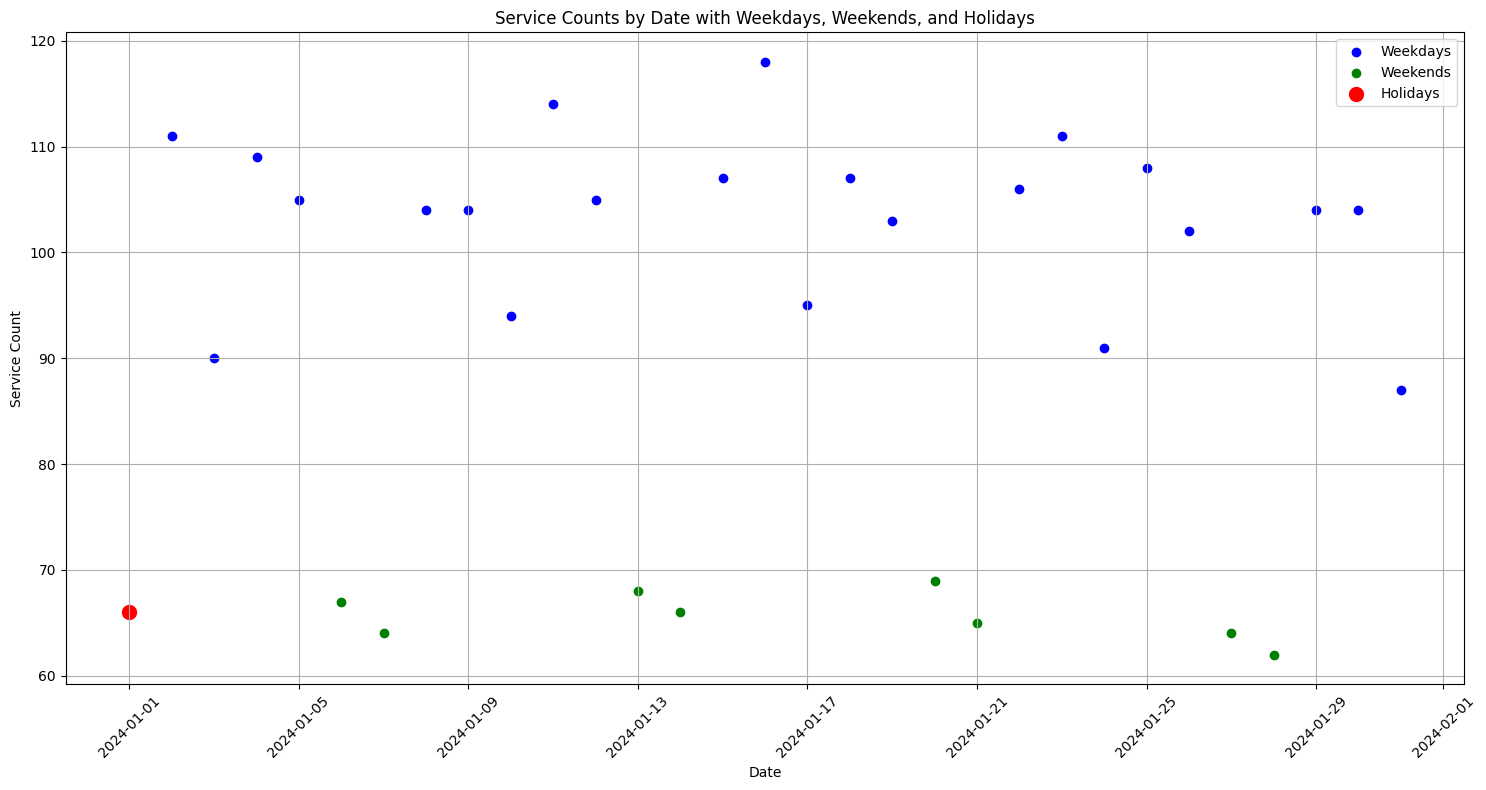

In [15]:
# Extracting weekdays and weekends
jan24_df['Day Type'] = np.where(jan24_df['Date'].dt.dayofweek < 5, 'Weekday', 'Weekend')

fr_holidays = holidays.France(years=2024) # extracting French holidays
jan24_df['Holiday'] = jan24_df['Date'].apply(lambda x: fr_holidays.get(x))

# Counting services per day and categorizing them
daily_services = jan24_df.groupby(['Date', 'Day Type']).size().reset_index(name='Service Count')
daily_services['Holiday'] = daily_services['Date'].apply(lambda x: fr_holidays.get(x) is not None)

# Plotting
plt.figure(figsize=(15, 8))
weekday_services = daily_services[daily_services['Day Type'] == 'Weekday']
plt.scatter(weekday_services['Date'], weekday_services['Service Count'], color='blue', label='Weekdays')
weekend_services = daily_services[daily_services['Day Type'] == 'Weekend']
plt.scatter(weekend_services['Date'], weekend_services['Service Count'], color='green', label='Weekends')
holiday_services = daily_services[daily_services['Holiday']]
plt.scatter(holiday_services['Date'], holiday_services['Service Count'], color='red', label='Holidays', s=100)
plt.title('Service Counts by Date with Weekdays, Weekends, and Holidays')
plt.xlabel('Date')
plt.ylabel('Service Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# Frequency of each service type by day of week
jan24_df['Day of Week'] = jan24_df['Date'].dt.day_name()
service_by_day = jan24_df.groupby(['Prestation', 'Day of Week']).size().unstack(fill_value=0)

fig = px.bar(service_by_day, barmode='group', labels={'value': 'Frequency', 'variable': 'Day of Week'}, title='Service Frequency by Day of the Week')
fig.show()

# Analyzing service corelation
service_combinations = jan24_df.pivot_table(index=['Date', 'ID Client'], columns='Prestation', aggfunc='size', fill_value=0)
service_correlation = service_combinations.corr()

fig = px.imshow(service_correlation, x=service_correlation.index, y=service_correlation.columns)
fig.update_layout(title='Service Correlation Heatmap')
fig.update_layout(height=600, width=800)  
fig.show()


In [17]:
# Average Duration of Each Service
jan24_df['Service Duration'] = (pd.to_datetime(jan24_df['Heure de fin'], format='%H:%M:%S') - 
                                pd.to_datetime(jan24_df['Heure de début'], format='%H:%M:%S')).dt.total_seconds() / 3600
average_duration = jan24_df.groupby('Prestation')['Service Duration'].mean()

fig = px.bar(average_duration, labels={'value': 'Average Duration (hours)', 'variable': 'Service'}, title='Average Duration of Each Service')
fig.show()


In [18]:

# Client-Caretaker Pairing Patterns
client_caretaker_pairing = jan24_df.groupby(['ID Client', 'ID Intervenant']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

print(client_caretaker_pairing.sort_values(by='Count', ascending=False))

      ID Client  ID Intervenant  Count
414   794098228       213237245     49
252   552306887       609468992     43
85     99999999        78005437     41
151   446362468       764144581     41
86     99999999        78007018     38
..          ...             ...    ...
453   833548586       854577575      1
454   846949801        78005437      1
455   855391156       888888888      1
456   858147751        78005437      1
500  1453084257       710283561      1

[501 rows x 3 columns]


In [19]:

#Peak Service Hours Analysis
jan24_df['Hour of Day'] = pd.to_datetime(jan24_df['Heure de début'], format='%H:%M:%S').dt.hour
peak_hours = jan24_df.groupby('Hour of Day').size()
fig = px.bar(peak_hours, labels={'value': 'Frequency', 'variable': 'Hour of Day'}, title='Peak Service Hours Analysis')
fig.show()


In [20]:

# Grouping data by caretaker and date to count the number of services provided each day
caretaker_daily_workload = jan24_df.groupby(['ID Intervenant', jan24_df['Date'].dt.date]).size()
caretaker_daily_workload = caretaker_daily_workload.reset_index(name='Daily Service Count')

# Grouping data by caretaker and week to count the number of services provided each week
jan24_df['Week'] = jan24_df['Date'].dt.isocalendar().week
caretaker_weekly_workload = jan24_df.groupby(['ID Intervenant', 'Week']).size()
caretaker_weekly_workload = caretaker_weekly_workload.reset_index(name='Weekly Service Count')

In [21]:
def plot_daily_workload(caretaker_daily_workload, caretaker_id):
    sample_caretaker = caretaker_daily_workload[caretaker_daily_workload['ID Intervenant'] == caretaker_id]
    fig = px.bar(sample_caretaker, x='Date', y='Daily Service Count', title=f'Daily Workload for Caretaker {caretaker_id}')
    fig.update_layout(xaxis_title='Date', yaxis_title='Number of Services')
    fig.show()

plot_daily_workload(caretaker_daily_workload, 78005437)


In [22]:
def plot_weekly_workload(caretaker_weekly_workload, caretaker_id):
    sample_caretaker_weekly = caretaker_weekly_workload[caretaker_weekly_workload['ID Intervenant'] == caretaker_id]
    fig = px.line(sample_caretaker_weekly, x='Week', y='Weekly Service Count', title=f'Weekly Workload for Caretaker {caretaker_id}', markers=True)
    fig.update_layout(xaxis_title='Week', yaxis_title='Number of Services')
    fig.show()

plot_weekly_workload(caretaker_weekly_workload, 78005437)
